## Load The Data

In [1]:
import pandas as pd
df = pd.read_csv('../Data/Amazon_Final_Labeled_Data.xlsx')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26818 entries, 0 to 26817
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   full_review  26780 non-null  object 
 1   emojis       26818 non-null  object 
 2   star_rating  26818 non-null  float64
 3   total_votes  26818 non-null  float64
 4   Labels       26818 non-null  object 
dtypes: float64(2), object(3)
memory usage: 1.0+ MB


In [3]:
df.dropna(inplace=True)

In [4]:
df.isnull().sum()

full_review    0
emojis         0
star_rating    0
total_votes    0
Labels         0
dtype: int64

In [5]:
df.dtypes

full_review     object
emojis          object
star_rating    float64
total_votes    float64
Labels          object
dtype: object

In [6]:
!pip install emoji

### Checking The Emojis Column Length 

In [7]:
import emoji


# Define a function to count the number of emojis in a string
def count_emojis(text):
    return len([c for c in text if c in emoji.EMOJI_DATA])

# Apply the function to each row of your dataframe
emoji_counts = df["emojis"].apply(lambda x: count_emojis(x))

# Calculate the minimum, maximum, and average number of emojis
min_emojis = emoji_counts.min()
max_emojis = emoji_counts.max()
avg_emojis = emoji_counts.mean()

# Print the results
print("The minimum number of emojis in a row is:", min_emojis)
print("The maximum number of emojis in a row is:", max_emojis)
print("The average number of emojis in a row is:", avg_emojis)

The minimum number of emojis in a row is: 1
The maximum number of emojis in a row is: 317
The average number of emojis in a row is: 1.8541075429424945


In [8]:
!pip install transformers

In [9]:
import torch

# Check if a GPU is available and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# BERT Emoji Model

BERT (Bidirectional Encoder Representations from Transformers) is a pre-trained 
transformer-based deep neural network developed by Google. BERT is designed to 
learn contextual relations between words in a sentence or text sequence, which makes it an excellent choice for various natural language processing tasks, including sentiment analysis and text classification.

In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import pandas as pd
import numpy as np

## Encoding The Labels 
The code imports the LabelEncoder class from the scikit-learn (sklearn) library's preprocessing module. LabelEncoder is a utility class that can be used to convert categorical data into numerical data.


In [11]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Encode the categorical labels to integer labels
df['Labels'] = label_encoder.fit_transform(df['Labels'])

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [12]:
print(label_encoder.classes_)

# Print the numerical mapping of each category
for i, category in enumerate(label_encoder.classes_):
    print(category, ":", i)


['Dissatisfaction' 'Efficacy' 'Satisfication' 'Side Effect' 'Uncertain']
Dissatisfaction : 0
Efficacy : 1
Satisfication : 2
Side Effect : 3
Uncertain : 4


In [13]:
# set warning to off
import logging
logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

## Dataset Class
This code defines a PyTorch Dataset class called **AmazonDataset**, which is used to preprocess and encode Amazon product reviews data for classification task. The dataset includes **`reviews`**, **`emojis`**, and **`labels`**. The tokenizer is used to tokenize the reviews and emojis and encode them into numerical values suitable for the model. The **`max_len`** parameter specifies the maximum sequence length for padding and truncation of reviews and emojis. The **getitem** method is used to return a dictionary of tensors that includes **`input_ids`**, **`attention_mask`**, **`token_type_ids`**, **`emojis`**, and **`labels`** for each item in the dataset. The encoding method uses the tokenizer to encode the review and emoji text and returns a dictionary of tensors. The **`emoji.demojize()`** function is used to convert emoji characters into text for processing. The Dataset class is designed to be used with PyTorch DataLoader to load batches of preprocessed data for training or evaluation of a BERT model.





In [14]:
import emoji

class AmazonDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.full_review = self.data['full_review']
        self.emojis = self.data['emojis']
        self.labels = self.data['Labels']
        self.max_len = max_len
    
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        review = str(self.full_review[index])
        review = " ".join(review.split())

        emoji_list = [emoji.demojize(e) for e in self.emojis[index].split()]
        emoji_text = " ".join(emoji_list)
        #print(emoji_text)

        encoding = self.tokenizer.encode_plus(
            review,
            emoji_text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'token_type_ids': encoding['token_type_ids'].flatten(),
            'emojis': torch.tensor([self.tokenizer.convert_tokens_to_ids(emoji_list)], dtype=torch.long), # convert list of strings to tensor
            'label': torch.tensor(self.labels[index], dtype=torch.long)
        }


## Load The Pre-trained Model & Tokenizer
This code initializes a **`BERT (Bidirectional Encoder Representations from Transformers)`** tokenizer and model from the pre-trained BERT-base-uncased checkpoint using the **from_pretrained()** method provided by the **transformers** library.

In [15]:
# Define tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
# Initialize BERT model
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Model Class
The given code defines a PyTorch neural network module called **SentimentClassifier**, which is used to perform sentiment analysis on Amazon product reviews using the **BERT** language model.

The module takes as input the preprocessed text and emoji data, as well as the precomputed encoding of the emojis using the tokenizer.

The architecture of the module includes:

*  A BERT model which encodes the text input
*  Two **attention** **mechanisms** for the text and emoji inputs respectively
*  A dense layer for classification

The text and emoji attention mechanisms are implemented as neural networks with several layers. The text attention mechanism computes a score for each word in the input text based on its importance to the sentiment analysis task. The emoji attention mechanism computes a score for each emoji in the input based on its relevance to the sentiment analysis task. These scores are used to weight the text and emoji representations before combining them into a single representation for the final classification.

The **dense layer** takes the concatenated text and emoji representations as input and outputs a probability distribution over the possible sentiment labels.

The **forward** method of the module performs the forward pass of the neural network by computing the BERT encoding of the input text, the attention scores for the text and emoji inputs, the weighted sum of the text and emoji representations, and the final classification logits. These logits can be converted to probabilities using a softmax function to obtain the predicted sentiment label for the input.


In [16]:
import torch.nn as nn
import torch

class SentimentClassifier(nn.Module):
    def __init__(self, bert_model, num_emojis, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()
        
        # BERT model
        self.bert_model = bert_model
        
        # Attention for text input
        self.text_attention = nn.Sequential(
            nn.Linear(hidden_size, 1),
            nn.Tanh(),
            nn.Softmax(dim=1)
        )
        
        # Attention for emoji input
        self.emoji_attention = nn.Sequential(
            nn.Linear(num_emojis, hidden_size),
            nn.Tanh(),
            nn.Softmax(dim=1)
        )
        
        # Dense layer for classification
        self.dense = nn.Linear(hidden_size * 2, num_classes)
    
    
    def forward(self, inputs_text, inputs_emojis, emoji_encoding):
        # BERT encoding
        bert_output = self.bert_model(input_ids=inputs_text, attention_mask=inputs_emojis)
        pooled_output = bert_output.pooler_output

        # Compute text attention scores
        text_scores = self.text_attention(bert_output.last_hidden_state)

        # Compute emoji attention scores
        emoji_scores = self.emoji_attention(emoji_encoding)

        # Weighted sum of text and emoji representations
        text_representation = (text_scores * bert_output.last_hidden_state).sum(dim=1)
        emoji_representation = (emoji_scores * emoji_encoding).sum(dim=1)
        combined_representation = torch.cat([text_representation, emoji_representation], dim=1)

        # Final classification
        logits = self.dense(combined_representation)
        return logits


## Train & Validation
This code defines a function called **"train"** which takes as input a PyTorch model, **training** and **validation** **dataloaders**, a loss function, an optimizer, a device (e.g. "cuda" for GPU or "cpu" for CPU), and a number of epochs to train for. The function trains the model for the specified number of epochs and returns the training loss history, validation loss history, and validation accuracy history.

The training loop consists of iterating over the batches in the training data loader, moving the batch to the specified device, zeroing the optimizer's gradients, performing a forward pass through the model, computing the loss, performing a backward pass and optimization, adding the batch loss to the total loss, and computing the accuracy. Every 100 batches, the training progress is printed to the console.

After training for each epoch, the model is evaluated on the validation data. The validation loop is similar to the training loop, except that gradients are not computed, and the loss and accuracy are calculated and stored for later analysis.

Finally, the function returns the training loss history, validation loss history, and validation accuracy history.





In [17]:
import torch
from sklearn.metrics import confusion_matrix, f1_score

def train(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs):
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []
    val_f1_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        # training loop
        for batch_idx, batch in enumerate(train_loader):
            # move batch to device
            input_ids = batch['input_ids'].to(device).to(torch.long)
            attention_mask = batch['attention_mask'].to(device).to(torch.long)
            emojis = batch['emojis'].to(device).to(torch.float32)
            labels = batch['label'].to(device).to(torch.long)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(input_ids, attention_mask, emojis)
            loss = loss_fn(outputs, labels)

            # backward pass and optimization
            loss.backward()
            optimizer.step()

            # add batch loss to total loss
            train_loss += loss.item()

            # calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

            # print training progress
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch + 1, batch_idx * len(input_ids), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

        # calculate average training loss and accuracy for the epoch
        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        train_loss_history.append(train_loss)

        # validation loop
        with torch.no_grad():
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0
            val_predictions = []
            val_targets = []
            for batch_idx, batch in enumerate(val_loader):
                # move batch to device
                input_ids = batch['input_ids'].to(device).to(torch.long)
                attention_mask = batch['attention_mask'].to(device).to(torch.long)
                emojis = batch['emojis'].to(device).to(torch.float32)
                labels = batch['label'].to(device).to(torch.long)

                # forward pass
                outputs = model(input_ids, attention_mask, emojis)
                val_loss += loss_fn(outputs, labels).item()

                # calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

                # add predictions and targets for confusion matrix and F1 score
                val_predictions += predicted.tolist()
                val_targets += labels.tolist()

            # calculate average validation loss, accuracy, confusion matrix, and F1 score for the epoch
            val_loss /= len(val_loader)
            val_acc = val_correct / val_total
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            val_confusion_matrix = confusion_matrix(val_targets, val_predictions)
            val_f1 = f1_score(val_targets, val_predictions, average='weighted')
            val_f1_history.append(val_f1)

        # print epoch results
        print('Epoch: {}\tTraining Loss: {:.6f}\tTraining Accuracy: {:.6f}\nValidation Loss: {:.6f}\tValidation Accuracy: {:.6f}\tValidation F1 Score: {:.6f}'.format(
              epoch + 1, train_loss, train_acc, val_loss, val_acc, val_f1))
        # print confusion matrix
        print('Confusion Matrix:\n', val_confusion_matrix)

    return train_loss_history, val_loss_history, val_acc_history, val_f1_history, val_confusion_matrix

## Test Function
This function takes in a trained model, test data loader, and device on which to run the evaluation. It then evaluates the model on the test data, computing the average loss and accuracy.

For each batch in the test data, the function moves the batch to the specified device and performs a forward pass through the model, computing the loss and updating the test loss. It then calculates the accuracy by comparing the predicted labels to the true labels and updating the test accuracy.

After iterating through all the batches in the test data, the function calculates the average test loss and accuracy and prints them. Finally, it returns the average test loss and accuracy.




In [18]:
from sklearn.metrics import classification_report, confusion_matrix

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    true_labels = []
    pred_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            # Move batch to device
            input_ids = batch['input_ids'].to(device).to(torch.long)
            attention_mask = batch['attention_mask'].to(device).to(device).to(torch.long)
            emojis = batch['emojis'].to(device).to(torch.float32)
            label = batch['label'].to(device).to(torch.long)

            # Forward pass
            logits = model(input_ids, attention_mask, emojis)
            loss = F.cross_entropy(logits, label)
            test_loss += loss.item()

            # Accuracy
            preds = torch.argmax(logits, axis=1)
            true_labels.extend(label.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())
            test_acc += (preds == label).sum().item()

    # Compute average loss and accuracy
    avg_test_loss = test_loss / len(test_loader)
    avg_test_acc = test_acc / len(test_loader.dataset)

    # Print classification report and confusion matrix
    print(f'Test loss: {avg_test_loss:.4f}, Test accuracy: {avg_test_acc:.4f}')
    print('Classification Report:\n', classification_report(true_labels, pred_labels))
    cm = confusion_matrix(true_labels, pred_labels)
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=LABELS, yticklabels=LABELS,
           xlabel='Predicted label',
           ylabel='True label',
           title='Confusion matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    
    return avg_test_loss, avg_test_acc



## Data Train Test Split
In this code, the train_test_split function from the sklearn.model_selection module is used to split a pandas DataFrame df into three sets: train_df, val_df, and test_df. The test_df is created with a size of 0.15, which means that 15% of the original data will be used for testing. Then, the train_val_df is split into train_df and val_df with a validation size of 0.15, which means that 15% of the data from train_val_df will be used for validation. The random_state parameter is set to 42 to ensure that the same split is obtained each time the code is run.

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (test size = 0.3)
train_val_df, test_df = train_test_split(df, test_size=0.15, random_state=42)

# Split the training and validation data (validation size = 0.15)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, random_state=42)

## Initializing Hyperparameters and Loading Data for Sentiment Analysis Model
The given code initializes hyperparameters for a sentiment analysis task using the BERT model. The MAX_LEN hyperparameter is set to 250, which is the maximum length of the input sequence that the model will accept. The BATCH_SIZE is set to 32, which is the number of samples that will be processed in each training iteration. The NUM_EPOCHS hyperparameter is set to 5, which is the number of times the model will be trained on the entire training dataset. The LEARNING_RATE hyperparameter is set to 2e-5, which is the rate at which the model will adjust its weights during training.

The code then creates datasets for the training, validation, and test sets using the AmazonDataset class and the given tokenizer. The AmazonDataset class is a custom dataset class that preprocesses and encodes the input text data into the appropriate format for BERT.

Next, the code creates dataloaders for the datasets, which are used to load the data into the model in batches during training. The train_loader is set to shuffle the data during training to prevent the model from memorizing the sequence of inputs.

The code then defines the loss function as CrossEntropyLoss(), which is commonly used for multi-class classification problems. The loss function is moved to the device using the to() method, which ensures that the loss function will be computed on the same device as the model.

The model is then moved to the device using the to() method, which ensures that the model will be trained on the same device as the data. The SentimentClassifier() class is a custom model class that uses the BERT model as a base and adds additional layers to classify the sentiment of the input text. The model has num_emojis set to 1, hidden_size set to 768, and num_classes set to 5.

Finally, the code initializes the optimizer as AdamW(), which is an optimizer commonly used with BERT. The model parameters are passed to the optimizer so that the optimizer can update the model weights during training.

In [20]:
# Initialize hyperparameters
MAX_LEN = 250
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 2e-5 

# Create datasets
train_dataset = AmazonDataset(train_df.reset_index(drop=True), tokenizer, MAX_LEN)
val_dataset = AmazonDataset(val_df.reset_index(drop=True), tokenizer, MAX_LEN)
test_dataset = AmazonDataset(test_df.reset_index(drop=True), tokenizer, MAX_LEN)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()

# Move model and loss function to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the sentiment classifier model
model = SentimentClassifier(bert_model=bert_model, num_emojis=1, hidden_size=768, num_classes=5)
model = model.to(device)

# 
loss_fn.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

## Training & Validating the Model

In [21]:
# call train function and store results
train_loss_history, val_loss_history, val_acc_history, val_f1_history, val_confusion_matrix = train(model, train_loader, val_loader, loss_fn, optimizer, device, NUM_EPOCHS)

Train Epoch: 1 [0/19348 (0%)]	Loss: 27.767529
Train Epoch: 1 [1600/19348 (8%)]	Loss: 1.124680
Train Epoch: 1 [3200/19348 (17%)]	Loss: 0.740547
Train Epoch: 1 [4800/19348 (25%)]	Loss: 0.560769
Train Epoch: 1 [6400/19348 (33%)]	Loss: 0.686004
Train Epoch: 1 [8000/19348 (41%)]	Loss: 0.826217
Train Epoch: 1 [9600/19348 (50%)]	Loss: 0.521320
Train Epoch: 1 [11200/19348 (58%)]	Loss: 0.830245
Train Epoch: 1 [12800/19348 (66%)]	Loss: 1.511775
Train Epoch: 1 [14400/19348 (74%)]	Loss: 0.668717
Train Epoch: 1 [16000/19348 (83%)]	Loss: 0.219920
Train Epoch: 1 [17600/19348 (91%)]	Loss: 0.458687
Train Epoch: 1 [19200/19348 (99%)]	Loss: 0.139454
Epoch: 1	Training Loss: 0.979061	Training Accuracy: 0.709221
Validation Loss: 0.445715	Validation Accuracy: 0.833089	Validation F1 Score: 0.819325
Confusion Matrix:
 [[   0    3    1    6   65]
 [   0 1672   29    0   12]
 [   0  124  495    5  214]
 [   0    1    1   37   16]
 [   0   34   45   14  641]]
Train Epoch: 2 [0/19348 (0%)]	Loss: 0.348766
Train Epo

Epoch: 9	Training Loss: 0.137167	Training Accuracy: 0.965319
Validation Loss: 0.509731	Validation Accuracy: 0.904832	Validation F1 Score: 0.904525
Confusion Matrix:
 [[  61    1    1    0   12]
 [   0 1661   48    2    2]
 [   0   35  753    2   48]
 [  10    0    2   41    2]
 [  11   22  119    8  574]]
Train Epoch: 10 [0/19348 (0%)]	Loss: 0.004605
Train Epoch: 10 [1600/19348 (8%)]	Loss: 0.029976
Train Epoch: 10 [3200/19348 (17%)]	Loss: 0.009025
Train Epoch: 10 [4800/19348 (25%)]	Loss: 0.009489
Train Epoch: 10 [6400/19348 (33%)]	Loss: 0.002671
Train Epoch: 10 [8000/19348 (41%)]	Loss: 0.019107
Train Epoch: 10 [9600/19348 (50%)]	Loss: 0.317164
Train Epoch: 10 [11200/19348 (58%)]	Loss: 0.092113
Train Epoch: 10 [12800/19348 (66%)]	Loss: 0.246145
Train Epoch: 10 [14400/19348 (74%)]	Loss: 0.004558
Train Epoch: 10 [16000/19348 (83%)]	Loss: 0.011818
Train Epoch: 10 [17600/19348 (91%)]	Loss: 0.195655
Train Epoch: 10 [19200/19348 (99%)]	Loss: 0.190067
Epoch: 10	Training Loss: 0.136231	Training

Train Epoch: 18 [8000/19348 (41%)]	Loss: 0.001265
Train Epoch: 18 [9600/19348 (50%)]	Loss: 0.010634
Train Epoch: 18 [11200/19348 (58%)]	Loss: 0.164094
Train Epoch: 18 [12800/19348 (66%)]	Loss: 0.220021
Train Epoch: 18 [14400/19348 (74%)]	Loss: 0.006148
Train Epoch: 18 [16000/19348 (83%)]	Loss: 0.925488
Train Epoch: 18 [17600/19348 (91%)]	Loss: 0.055145
Train Epoch: 18 [19200/19348 (99%)]	Loss: 0.173658
Epoch: 18	Training Loss: 0.092901	Training Accuracy: 0.980722
Validation Loss: 0.858384	Validation Accuracy: 0.894583	Validation F1 Score: 0.893660
Confusion Matrix:
 [[  56    1    0    0   18]
 [   0 1672   38    0    3]
 [   0   47  656    1  134]
 [   9    0    1   33   12]
 [  13   24   56    3  638]]
Train Epoch: 19 [0/19348 (0%)]	Loss: 0.002107
Train Epoch: 19 [1600/19348 (8%)]	Loss: 0.000594
Train Epoch: 19 [3200/19348 (17%)]	Loss: 0.071991
Train Epoch: 19 [4800/19348 (25%)]	Loss: 0.044582
Train Epoch: 19 [6400/19348 (33%)]	Loss: 0.004164
Train Epoch: 19 [8000/19348 (41%)]	Loss: 

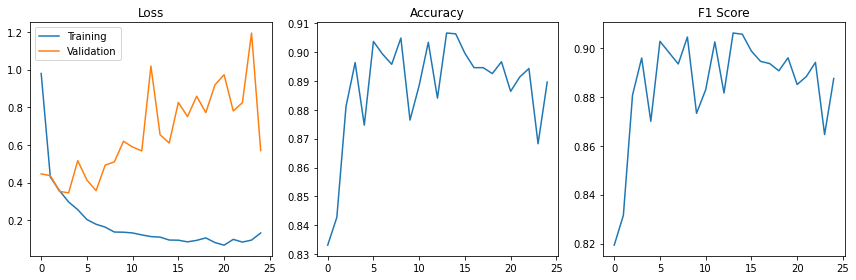

In [22]:
import matplotlib.pyplot as plt

# visualize results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(train_loss_history, label='Training')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_acc_history)
plt.title('Accuracy')

plt.subplot(1, 3, 3)
plt.plot(val_f1_history)
plt.title('F1 Score')

plt.tight_layout()
plt.show()

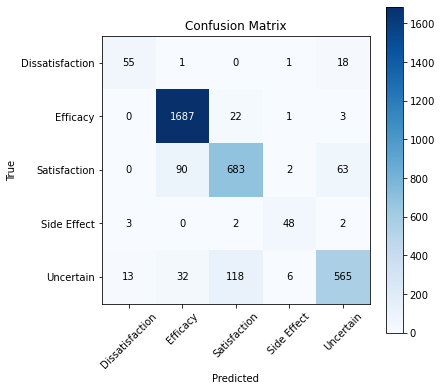

In [23]:
# define the labels
LABELS = ['Dissatisfaction', 'Efficacy', 'Satisfaction', 'Side Effect', 'Uncertain']
# plot confusion matrix for last epoch
plt.figure(figsize=(6, 6))
plt.imshow(val_confusion_matrix, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks(ticks=[0, 1, 2, 3, 4], labels=LABELS, rotation=45)
plt.yticks(ticks=[0, 1, 2, 3, 4], labels=LABELS, )
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
# display values in each cell of the confusion matrix
thresh = val_confusion_matrix.max() / 2.
for i in range(val_confusion_matrix.shape[0]):
    for j in range(val_confusion_matrix.shape[1]):
        plt.annotate(str(val_confusion_matrix[i, j]), xy=(j, i), 
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white' if val_confusion_matrix[i, j] > thresh else 'black')
plt.show()


## Testing the Model

Test loss: 0.5878, Test accuracy: 0.8875
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.54      0.60        89
           1       0.94      0.99      0.97      1980
           2       0.82      0.81      0.82       989
           3       0.79      0.80      0.79        65
           4       0.85      0.79      0.82       894

    accuracy                           0.89      4017
   macro avg       0.82      0.79      0.80      4017
weighted avg       0.88      0.89      0.89      4017



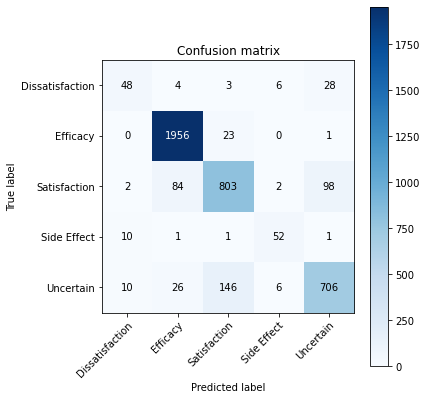

In [24]:
import torch.nn.functional as F


test_loss, test_acc = test(model, test_loader, device)

## Saving the Model

In [25]:
# Save the trained model
torch.save(model.state_dict(), 'emoji_text_model.pt')